In [1]:
import numpy as np
import os
import tensorflow as tf
import keras

In [2]:
# initializing train and test lists

x_train, y_train, x_test, y_test= [], [], [], []

In [3]:
# loading data

faces_dir= 'att_faces/'

sub_f= sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

In [6]:
from keras.preprocessing.image import  load_img, img_to_array
from keras.preprocessing import image

In [7]:
# loading data into list vars
from PIL import Image


for subject_id, folders in enumerate(sub_f):
    for file in sorted(os.listdir(folders)):
        img= load_img(folders+ '/' +file, color_mode= 'grayscale')
        img= img_to_array(img).astype('float32')/255
        if subject_id <35:
            x_train.append(img)
            y_train.append(subject_id)
        else:
            x_test.append(img)
            y_test.append(subject_id-35)

In [8]:
# images --> array
x_train= np.array(x_train)
y_train= np.array(y_train)

x_test= np.array(x_test)
y_test= np.array(y_test)

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, Input

## Designing the model

According to the SNN (Siamese Neural Net) architecture, only network is enough to create both the top and bottom instances. The reason being, that the single instance can be reused as the weights are to be shared.

In [10]:
def network(input_shape):
    model= Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu',
                     input_shape= input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation= 'sigmoid'))
    return model

In [11]:
# taking the input shape
input_shape= x_train.shape[1:]

# instantiating the shared network
shared_net= network(input_shape)

# defining the top and bottom inputs
top_input= Input(shape= input_shape)
bottom_input= Input(shape= input_shape)

# defining the top and bottom outputs
top_output= shared_net(top_input)
bottom_output= shared_net(bottom_input)


In [12]:
from keras import backend as k

# function to compute the euclidean distance
def euc_dist(vectors):
    vector1, vector2= vectors
    sum_of_squares= k.sum(k.square(vector1-vector2), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_of_squares, k.epsilon()))

### In the below code cell, we have used Lambda layer to define our own layer by wrapping an arbitary function as a Layer object.

In [13]:
from keras.layers import Lambda

# Euclidean function wrapped inside lambda layer
distance= Lambda(euc_dist, output_shape=(1,))([top_output, bottom_output])

In [14]:
# combining distance layer with the previously prepared top and bottom inputs

from keras.models import Model
model= Model( [top_input, bottom_input], outputs=distance)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          18744768    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

# Training

In [16]:
import random

# creating pairs of araays of images with their labels

def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  
    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)
      
            # create negative pair
            # first, create list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0)

    return np.array(pairs), np.array(labels)

        

In [17]:
num_classes= len(np.unique(y_train))
training_pairs, training_labels= create_pairs(x_train, y_train,
                                             num_classes)

test_pairs, test_labels= create_pairs(x_test, y_test, len(np.unique(y_test)))

# Defining the loss and accuracy

In [18]:
def contrastive_loss(y_true, D):
    margin = 1
    return k.mean(y_true * k.square(D) + (1 - y_true) * k.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return k.mean(k.equal(y_true, k.cast(y_pred < 0.5, y_true.dtype)))

In [19]:
# maintaining the same data type for bothe the input parameters
training_labels= k.cast(training_labels, training_pairs.dtype)

In [20]:
model.compile(loss= contrastive_loss, optimizer='adam', metrics= accuracy)

model.fit([training_pairs[:,0], training_pairs[:,1]], 
          training_labels, batch_size=128, epochs=10)

Epoch 1/10
5/5 [==============================] - 55s 11s/step - loss: 0.2749 - accuracy: 0.7453
Epoch 2/10
5/5 [==============================] - 26s 5s/step - loss: 0.1377 - accuracy: 0.8767
Epoch 3/10
5/5 [==============================] - 26s 5s/step - loss: 0.0900 - accuracy: 0.9431
Epoch 4/10
5/5 [==============================] - 26s 5s/step - loss: 0.0623 - accuracy: 0.9698
Epoch 5/10
5/5 [==============================] - 30s 6s/step - loss: 0.0442 - accuracy: 0.9904: 10s - loss: 0.0434 - accuracy: 0
Epoch 6/10
5/5 [==============================] - 25s 5s/step - loss: 0.0376 - accuracy: 0.9919
Epoch 7/10
5/5 [==============================] - 26s 5s/step - loss: 0.0309 - accuracy: 0.9953
Epoch 8/10
5/5 [==============================] - 25s 5s/step - loss: 0.0279 - accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 25s 5s/step - loss: 0.0206 - accuracy: 0.9983
Epoch 10/10
5/5 [==============================] - 25s 5s/step - loss: 0.0170 - accuracy: 1.0000


In [21]:
idx1, idx2= 1, 37
img1= np.expand_dims(x_test[idx1], axis=0)
img2= np.expand_dims(x_test[idx2], axis=0)

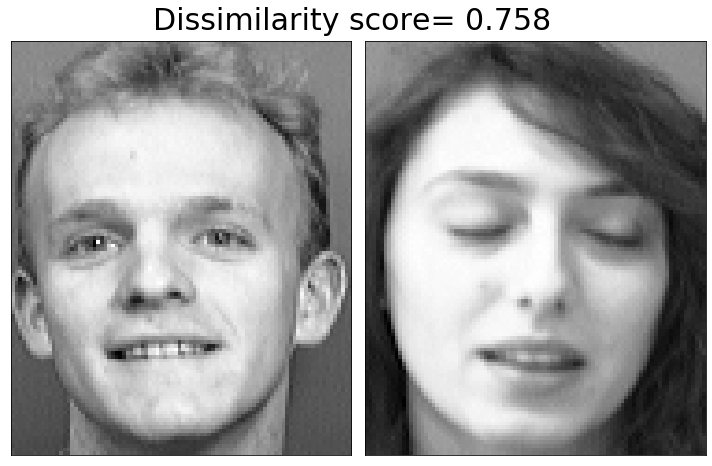

In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2)= plt.subplots( 1, 2 , figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
dissimilarity= model.predict([img1, img2])[0][0]
fig.suptitle('Dissimilarity score={: .3f} '.format( dissimilarity), size=30)
plt.tight_layout()
plt.show()

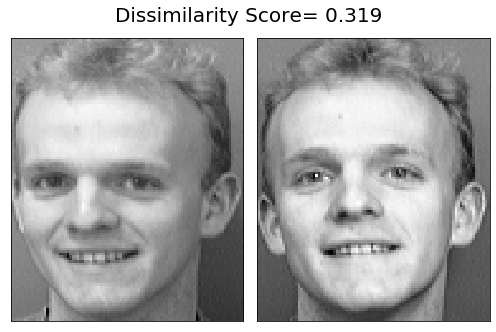

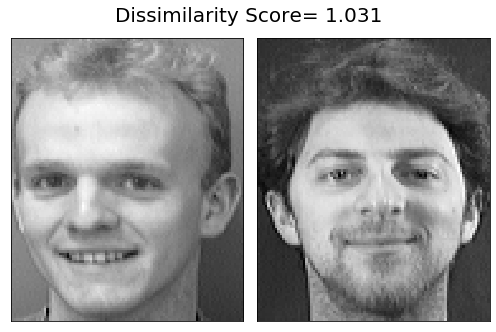

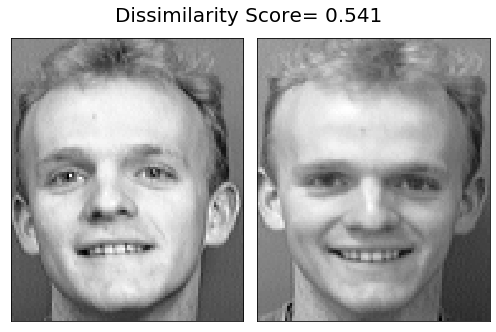

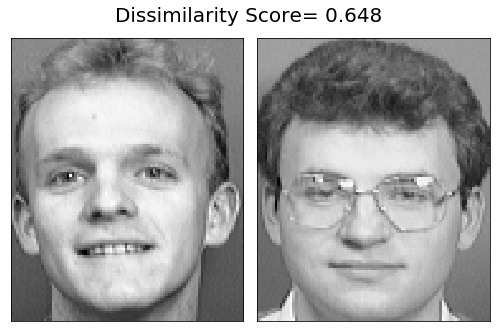

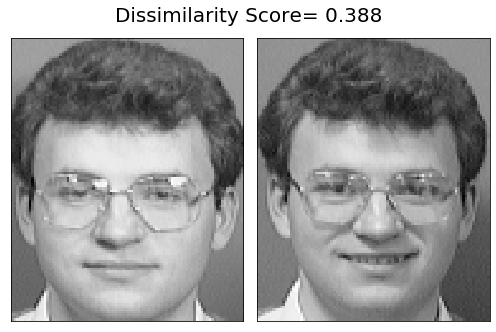

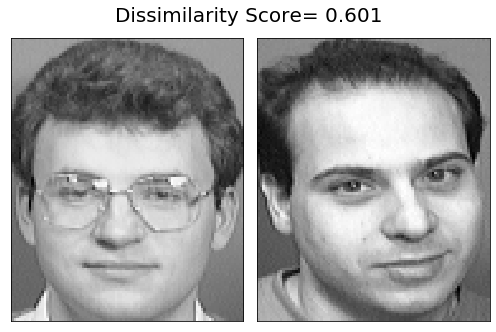

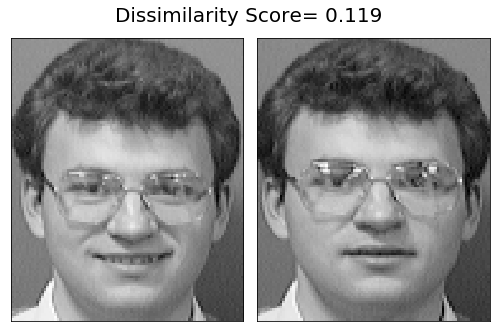

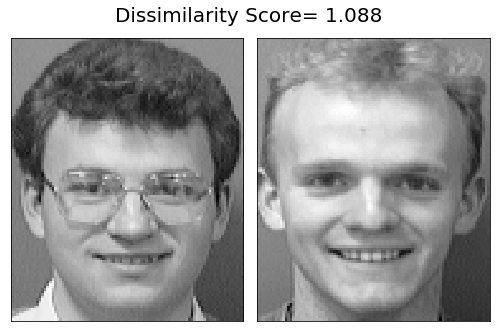

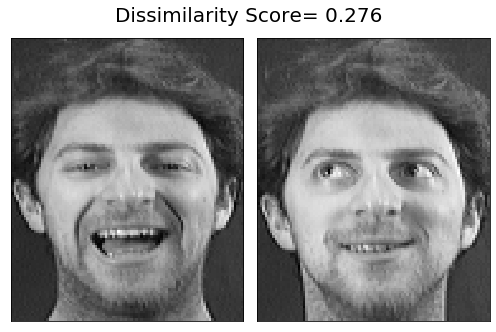

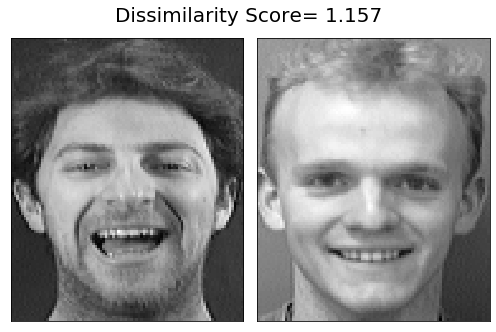

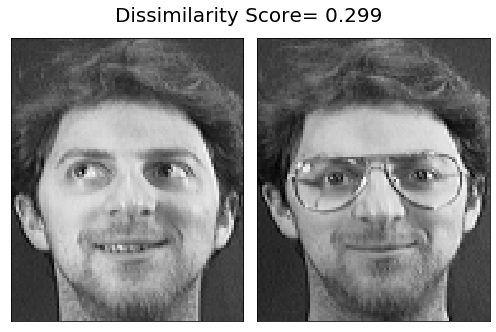

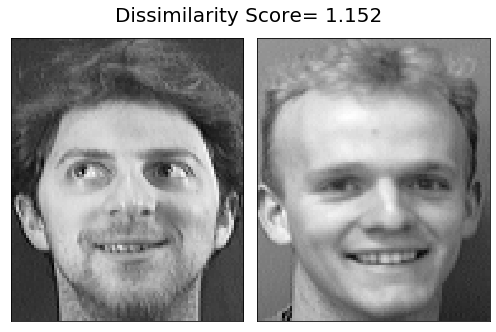

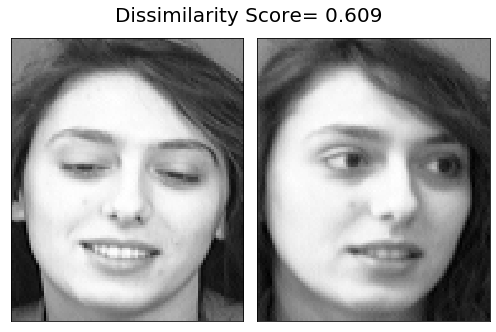

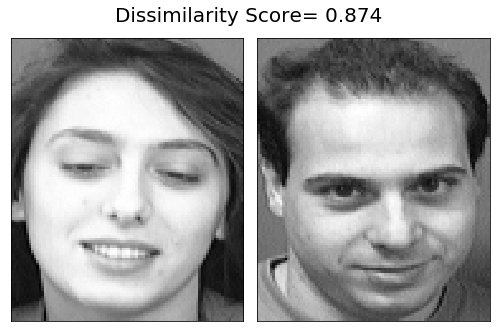

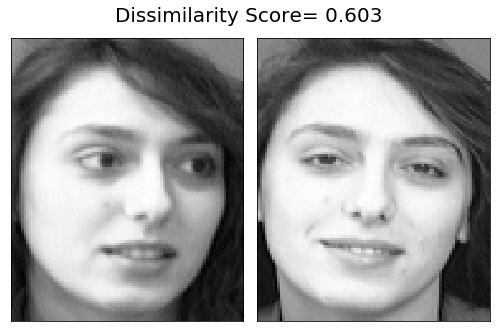

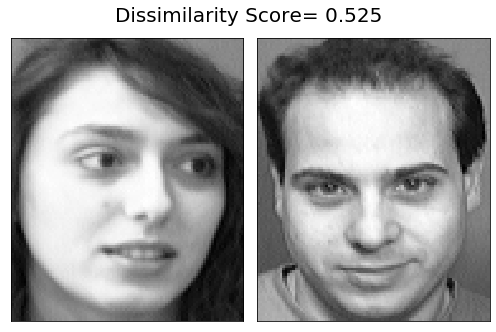

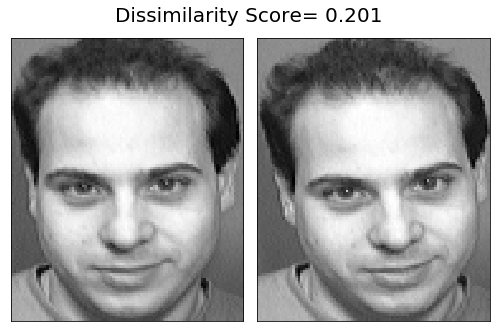

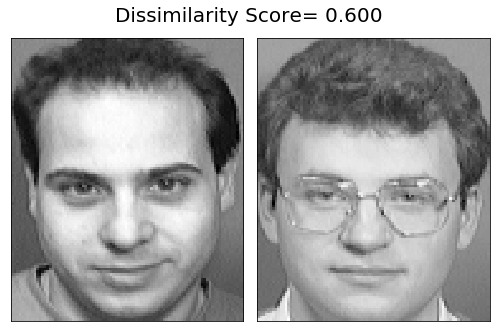

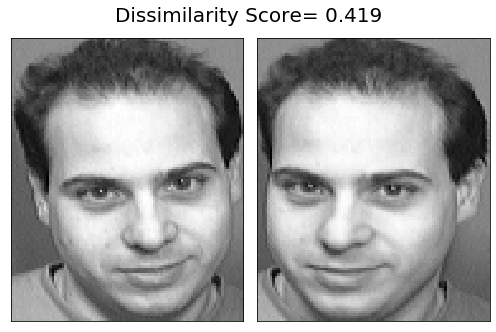

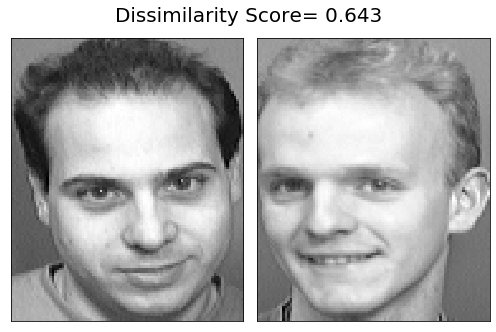

In [23]:
for i in range (5):
    for n in range (0,4):
        fig, (ax1, ax2)= plt.subplots(1,2, figsize=(7,5))
        img1= np.expand_dims(test_pairs[i*20 +n, 0], axis=0)
        img2= np.expand_dims(test_pairs[i*20+n, 1], axis=0)
        dissimilarity= model.predict([img1, img2])[0][0]
        img1, img2= np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        
        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        fig.suptitle('Dissimilarity Score= {:.3f}'.format(dissimilarity), size=20)
plt.show()

In [24]:
model.save('siamesenn.h5')